In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import datetime 
rc('font', family='AppleGothic') 			
plt.rcParams['axes.unicode_minus'] = False
nameArray = ['박하원','하효은','이민우','강명균','유지원','손정민','이채별']

In [20]:
def judgeSleep1(row):
    return (row['mot_rolling_mean'] <= 0.15) & (row['br_conv_rolling_mean'] >= 0.9)

def judgeSleep2(row):
    return (row['mot_rolling_mean'] <= 0.1) & (row['br_conv_rolling_mean'] > 0.7)

def judgePresent1(row):
    return row['hr'] != 0  

def judgeRestOrActive(row):
    if row['mot_rolling_mean'] > 0.3:
        return 3
    else:
        return 2

def judgeAbsenceOrPresent(row):
    if row['mot_rolling_mean'] > 0.5:
        return 3
    elif row['mot_rolling_mean'] > 0.3:
        return 2
    else: 
        return 4


def judgeData(dataFrame):
    absenceCount = 0
    absenceOutlierCount = 0
    lastingCount = 0
    lastingSum = 0
    presentData = None
    lastingData = None
    for i in range(0, len(dataFrame)):
        row = dataFrame.iloc[i]
        if judgePresent1(row):
            absenceCount = 0
            if judgeSleep1(row) or judgeSleep2(row):
                dataFrame.loc[i, 'new_status'] = 4
            else: 
                dataFrame.loc[i, 'new_status'] = judgeRestOrActive(row)
            presentData = dataFrame.iloc[i] 
        else:
            absenceCount += 1
            if presentData is not None:
                if (row['r'] - presentData['r']) > 0.5:
                    dataFrame.loc[i, 'new_status'] = 0
                else:
                    dataFrame.loc[i, 'new_status'] = presentData['new_status']
                
                if absenceCount > 60:
                    presentData = None
                    dataFrame.loc[i, 'new_status'] = 0

            else:
                if lastingData is not None:
                    lastingCount += 1
                    if lastingCount <= 10:
                        dataFrame.loc[i, 'new_status'] = lastingData['new_status']
                        continue
                    else: 
                        lastingData = None
                        lastingCount = 0
                if row['mot_rolling_mean'] <= 0.15:
                    absenceOutlierCount = 0
                    dataFrame.loc[i, 'new_status'] = 0
                else:
                    absenceOutlierCount += 1
                    if absenceOutlierCount > 10:
                        dataFrame.loc[i, 'new_status'] = judgeAbsenceOrPresent(row)
                        lastingData = dataFrame.iloc[i]
                    else:
                        dataFrame.loc[i, 'new_status'] = 0
    return dataFrame

In [21]:
#수면, 활동 전체 데이터 
sleepDf = pd.read_csv("/Users/hyennaeon/Desktop/Hatinroo/HatinrooData/수면_활동_부재_수집데이터/SleepData.csv")
activeDf = pd.read_csv("/Users/hyennaeon/Desktop/Hatinroo/HatinrooData/수면_활동_부재_수집데이터/ActiveData.csv")

personalActiveDf = activeDf
personalSleepDf = sleepDf

personalActiveDf['br_conv_rolling_mean'] = personalActiveDf['br_conv'].rolling(window=10).mean()
personalActiveDf['mot_rolling_mean'] = personalActiveDf['mot'].rolling(window=10).mean()

personalSleepDf['br_conv_rolling_mean'] = personalSleepDf['br_conv'].rolling(window=10).mean()
personalSleepDf['mot_rolling_mean'] = personalSleepDf['mot'].rolling(window=10).mean()

personalActiveDf = personalActiveDf.reset_index(drop=True)
personalSleepDf = personalSleepDf.reset_index(drop=True)

#judgeData 함수로 new status 재정의한 후 리턴된 dataFrame 다시 대입
personalSleepDf = judgeData(personalSleepDf)
personalActiveDf = judgeData(personalActiveDf)

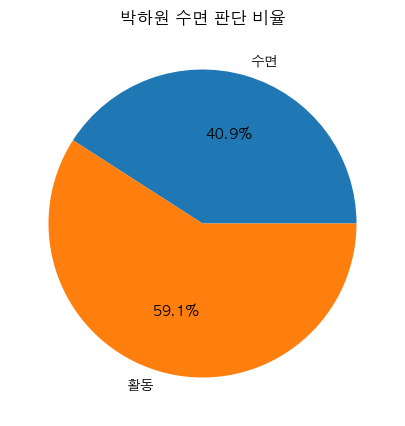

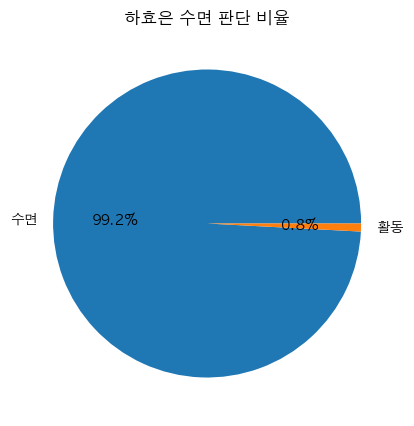

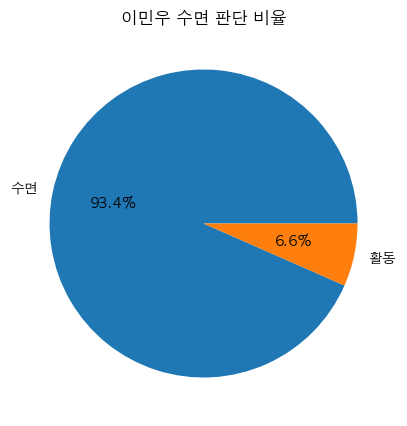

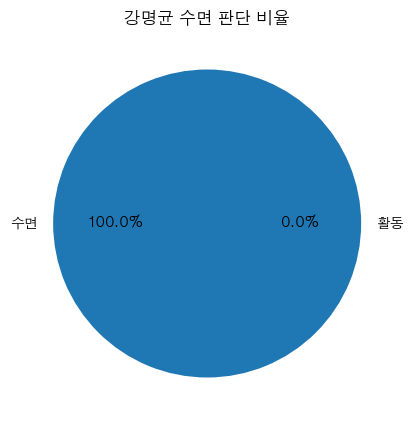

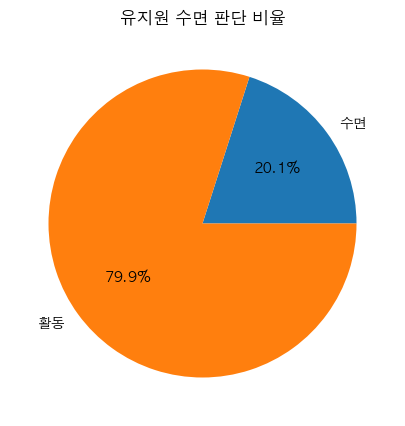

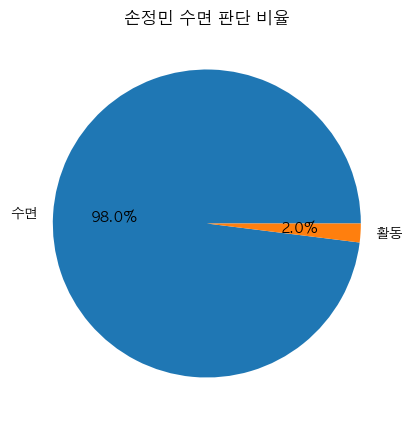

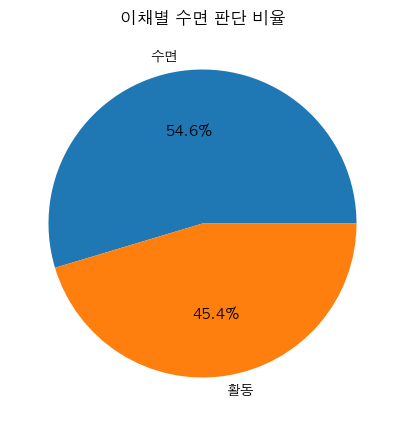

In [48]:
label = ['수면', '활동']

for i in range(7):
    Df = personalSleepDf
    Df = Df[Df['userId'] == i]
    sample_sleep = len(Df[(Df['status'] == 4)])
    sample_active = len(Df[(Df['status'] != 4)])

    plt.figure(figsize=(6, 5))
    plt.pie([sample_sleep, sample_active], labels=label, autopct='%.1f%%')
    plt.title(nameArray[i]+" 수면 판단 비율")
    # plt.savefig(f"/Users/hyennaeon/Desktop/Hatinroo/HatinrooData/"+nameArray[i]+"sleep.png", bbox_inches='tight')
    plt.show()

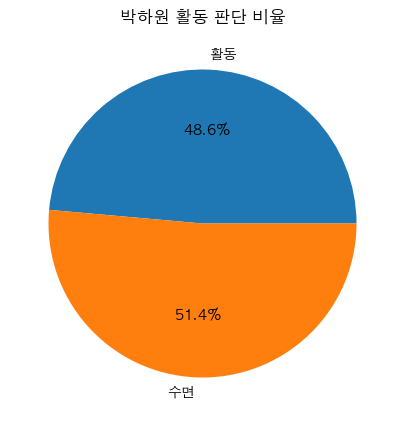

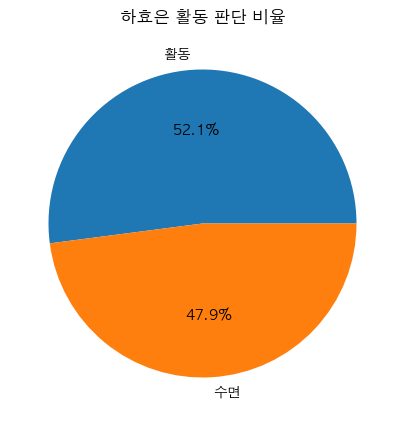

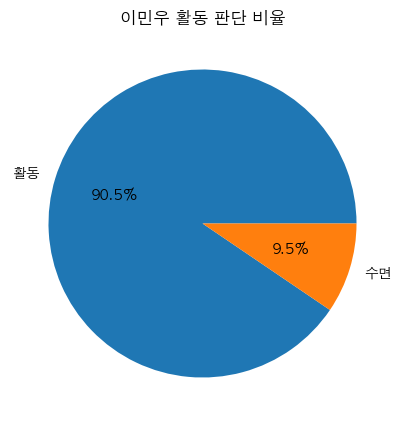

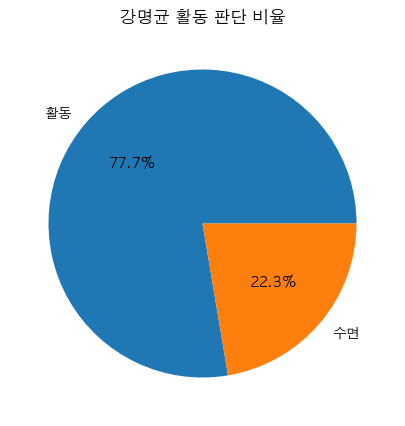

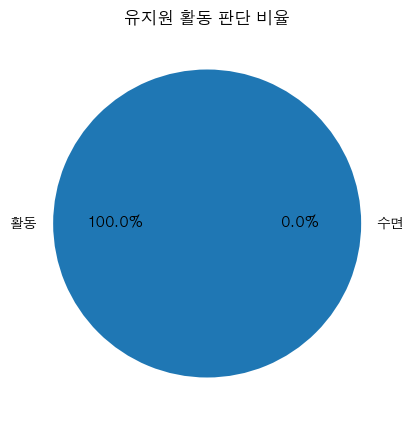

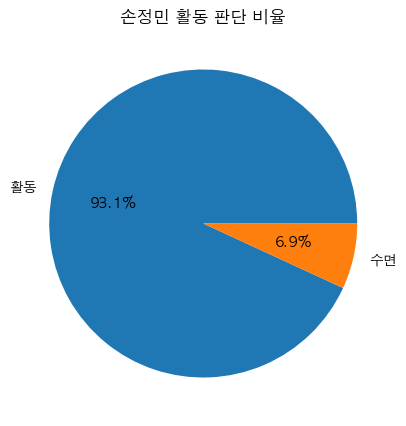

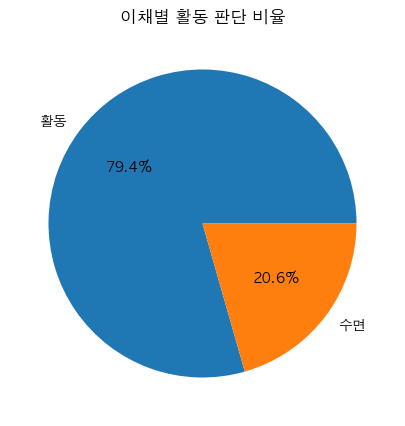

In [50]:
label = ['활동', '수면']

for i in range(7):
    Df = personalActiveDf
    Df = Df[Df['userId'] == i]
    sample_sleep = len(Df[(Df['status'] != 4)])
    sample_active = len(Df[(Df['status'] == 4)])

    plt.figure(figsize=(6, 5))
    plt.pie([sample_sleep, sample_active], labels=label, autopct='%.1f%%')
    plt.title(nameArray[i]+" 활동 판단 비율")
    # plt.savefig(f"/Users/hyennaeon/Desktop/Hatinroo/HatinrooData/"+nameArray[i]+"sleep.png", bbox_inches='tight')
    plt.show()

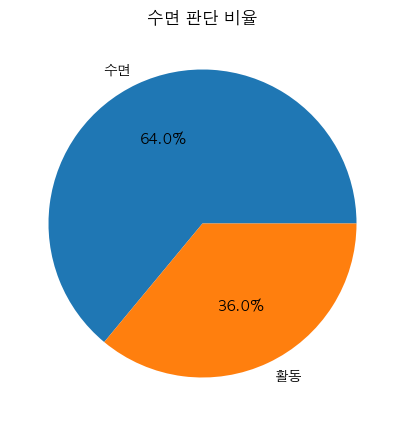

In [51]:
label = ['수면', '활동']

Df = personalSleepDf
sample_sleep = len(Df[(Df['status'] == 4)])
sample_active = len(Df[(Df['status'] != 4)])

plt.figure(figsize=(6, 5))
plt.pie([sample_sleep, sample_active], labels=label, autopct='%.1f%%')
plt.title("수면 판단 비율")
plt.savefig(f"/Users/hyennaeon/Desktop/Hatinroo/HatinrooData/전체수면판단비율.png", bbox_inches='tight')
plt.show()

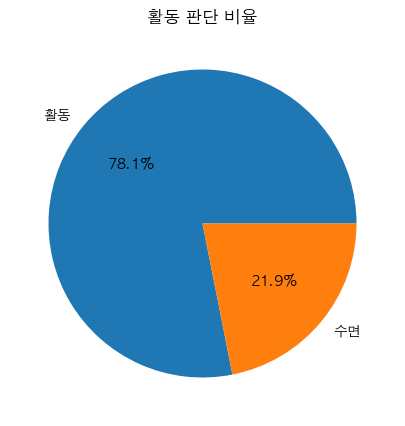

In [52]:
label = ['활동', '수면']

Df = personalActiveDf
sample_sleep = len(Df[(Df['status'] != 4)])
sample_active = len(Df[(Df['status'] == 4)])

plt.figure(figsize=(6, 5))
plt.pie([sample_sleep, sample_active], labels=label, autopct='%.1f%%')
plt.title("활동 판단 비율")
plt.savefig(f"/Users/hyennaeon/Desktop/Hatinroo/HatinrooData/전체활동판단비율.png", bbox_inches='tight')
plt.show()